<a href="https://colab.research.google.com/github/GermanOmar/SLM-ML/blob/master/ML_SLM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative evaluation of supervised machine learning algorithms in the prediction of the relative density of 316L stainless steel fabricated by selective laser melting


<a href="https://ibb.co/9ctkgc3"><img src="https://i.ibb.co/mb8VTbF/SLM1.png" WIDTH="430" HEIGHT="300"  border="0"></a>

In [1]:
!pip install -q "tqdm>=4.36.1"
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1MB 8.8MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import tensorflow_addons as tfa
from sklearn.inspection import permutation_importance

## Upload database:

In [4]:
#Dataset
data = pd.read_table('dataf.txt') 
data.describe()

,P,V,L,H,PS,RD
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,152.142857,702.048571,0.061071,0.085536,34.792857,97.714107
std,55.369276,470.429449,0.103082,0.029617,5.190024,1.837672
min,70.000000,18.760000,0.020000,0.020000,16.000000,91.200000
25%,100.000000,250.000000,0.020000,0.060000,30.000000,97.000000
50%,150.000000,700.000000,0.030000,0.080000,35.000000,98.350000
75%,200.000000,1000.000000,0.050000,0.110000,38.000000,98.922500
max,300.000000,2000.000000,0.460000,0.150000,48.000000,99.900000


<a href="https://ibb.co/VwbhKLc"><img src="https://i.ibb.co/1zBpS0t/SLM2.png" WIDTH="550" HEIGHT="380"  border="0"></a>

##Setting inputs - output:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


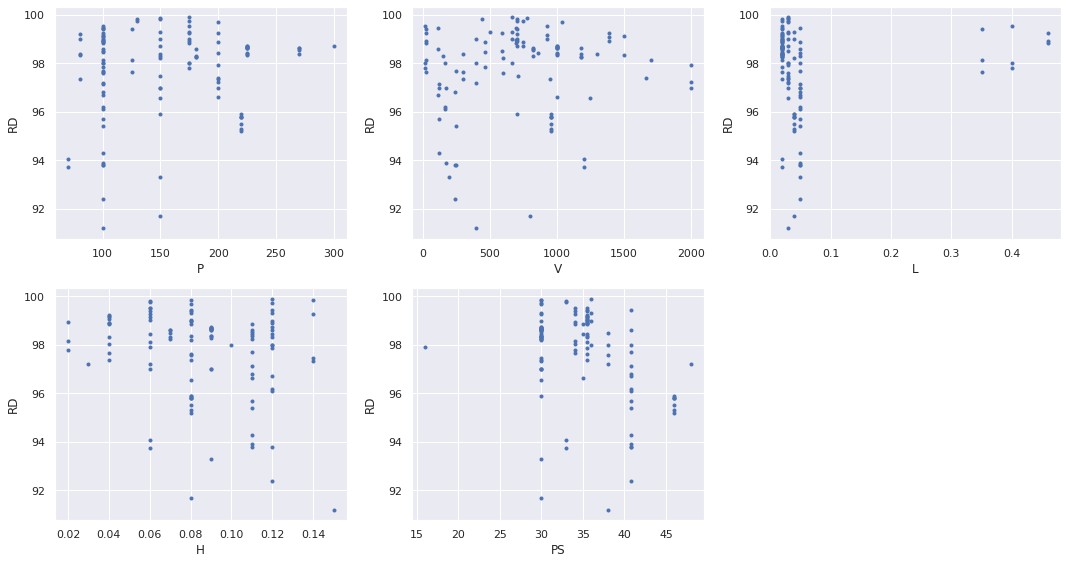

In [5]:
fields = ['P', 'V','L','H','PS']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(2, 3, i + 1)
  plt.plot(data[field], data['RD'], 'b.')
  plt.xlabel(field)
  plt.ylabel('RD')

plt.tight_layout()

X=data[['P', 'V','L','H','PS']]
Y=data['RD'][:,None]



## Normalize


In [6]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu


X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

## Split data

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=2)        
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.21, random_state=42)
#print('training samples:', X_train.shape[0], ' validation samples:', X_val.shape[0],  ' test samples:', X_test.shape[0])
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 89  test samples: 23


# 1.-Gradient boosting regressor

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
#HIPERPARAMETERS
params = {'n_estimators': 5000, 'max_depth': 10, 'min_samples_split': 5, 'max_leaf_nodes': 8,
          'learning_rate': 0.001, 'random_state': 42,'loss': 'ls'}
#KERNEL
model1 = GradientBoostingRegressor(**params)

#TRAINING
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False, leave_overall_progress = True)
history = model1.fit(X_train,y_train)
from sklearn.metrics import mean_squared_error
#mse = mean_squared_error(y_val, model1.predict(X_val))
mse = mean_squared_error(y_test, model1.predict(X_test))
print("The mean squared error (MSE) on validation set: {:.4f}".format(mse))


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on validation set: 0.3951


Gradient boosting regressor
MSE train: 0.07933878834759701
MSE test: 0.6183431298777521
MSE train < MSE test? True

R2_train:  0.9199453083395046
R2_test:  0.3966502814098799
RMSE:  1.5069611167697678
MAPE:  2.250213868863536
IM:  2.777044045603667


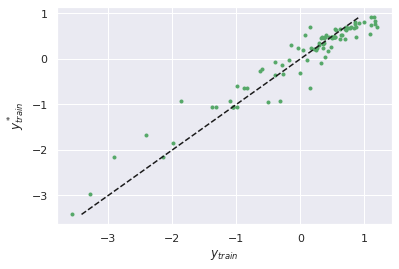

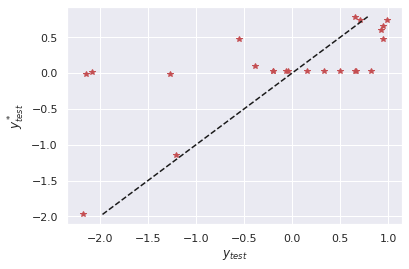

In [72]:
#TESTING
y_star_train = model1.predict(X_train)
#y_star_val = model1.predict(X_val)
y_star_test = model1.predict(X_test)

#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gradient boosting regressor")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model1.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)

#2.-Gaussian Process

Gaussian Process
MSE train: 0.034437497336276386
MSE test: 0.6183431298777521
MSE train < MSE test? True

R2_train:  0.9652517603528762
R2_test:  0.3966502814098799
RMSE:  0.6183431298777521
MAPE:  0.8096583580494294
IM:  1.0932640709219568


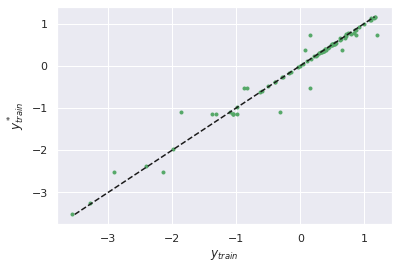

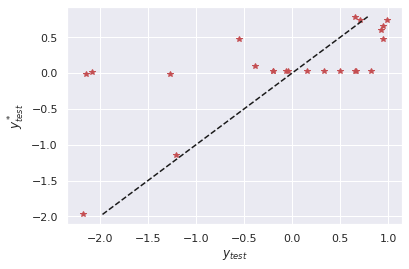

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model2=GPR(kernel=kernel, n_restarts_optimizer=10, alpha=0.01, normalize_y=True)
 
#Training
model2.fit(X_train,y_train)
 
#Testing
y_star_train = model2.predict(X_train)
y_pred = model2.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
#METRICS: R2, RMSE, MAPE
y_pred = model2.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)


# 3.-Random forest regressor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random forest regressor
MSE train: 0.13735927629724953
MSE test: 0.4637832807955221
MSE train < MSE test? True

R2_train:  0.8614012800081015
R2_test:  0.5474624064957223
RMSE:  1.3879989233512968
MAPE:  2.013088129376085
IM:  2.5057493718218016


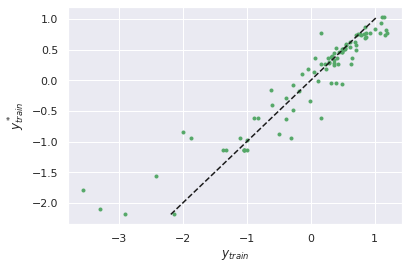

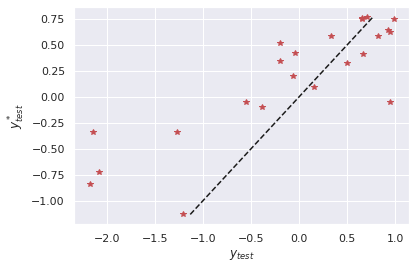

In [74]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
model3=RandomForestRegressor(n_estimators=100,max_depth=20)

#TRAINING
model3.fit(X_train,y_train)

#Testing
y_star_train = model3.predict(X_train)
y_pred = model3.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Random forest regressor")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model3.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)

# 4.-Support vector regression

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor
MSE train: 0.6435743061554844
MSE test: 0.7601065465425635
MSE train < MSE test? True

R2_train:  0.35061848418743824
R2_test:  0.2583243044268446
RMSE:  1.4007592452081186
MAPE:  2.1268212071042565
IM:  2.5597316961513834


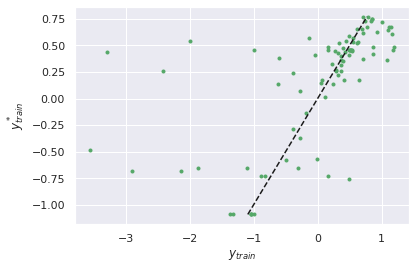

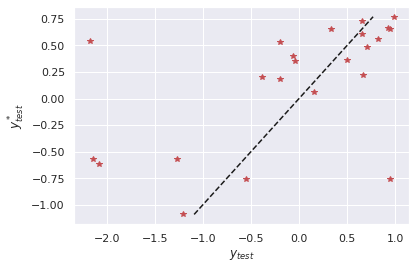

In [75]:
from sklearn.svm import SVR
#KERNEL
model4=SVR()
#svr=SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

#START TRAINING
model4.fit(X_train,y_train)

#Testing
y_star_train = model4.predict(X_train)
y_pred = model4.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Random forest regressor")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model4.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)

# 5.-Decision tree regressor

Random forest regressor
MSE train: 0.0391934409395735
MSE test: 0.5590960487748663
MSE train < MSE test? True

R2_train:  0.9604529021065341
R2_test:  0.45446075585920287
RMSE:  1.7554438200505855
MAPE:  2.564863895244678
IM:  3.141121517085834


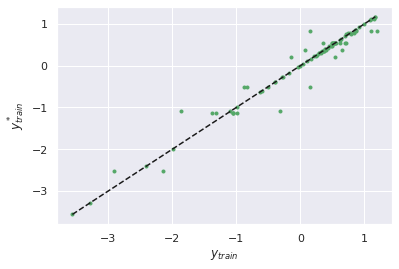

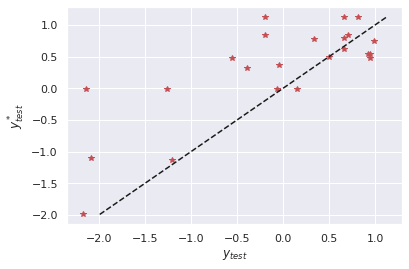

In [76]:
from sklearn.tree import DecisionTreeRegressor
model5=DecisionTreeRegressor(max_depth=10)

#START TRAINING
model5.fit(X_train,y_train)

#Testing
y_star_train = model5.predict(X_train)
y_pred = model5.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Random forest regressor")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model5.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)


# 6.- K-Nearest Neighbors


Random forest regressor
MSE train: 0.3966161064100466
MSE test: 0.5358545401732014
MSE train < MSE test? True

R2_train:  0.5998050793624936
R2_test:  0.4771387108600075
RMSE:  0.5358545401732014
MAPE:  1.817638512731876
IM:  1.9541267104749191


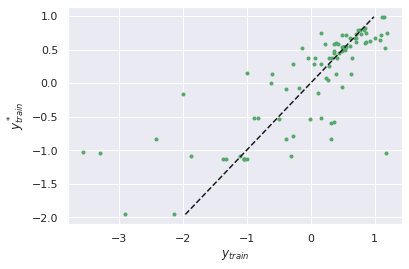

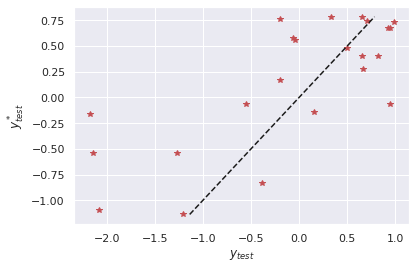

In [77]:
from sklearn.neighbors import KNeighborsRegressor
#KERNEL
model6 = KNeighborsRegressor(n_neighbors=3)

#START TRAINING
model6.fit(X_train,y_train)

#Testing
y_star_train = model6.predict(X_train)
y_pred = model6.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Random forest regressor")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model6.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)


# 7.- Neural Networks

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from sklearn.ensemble import BaggingRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

In [78]:
width = 10
depth = 5
L2 = 0.001

net_input = Input(shape=(Xn.shape[1],),name='input')

net_output = Sequential([Dense(width, 'relu', kernel_regularizer=regularizers.l2(L2))]*(depth - 1) + [Dense(1, 'linear', kernel_regularizer=regularizers.l2(L2))], name = 'base_NN')(net_input) 
#net_output = Sequential([Dense(width, 'relu')]*(depth - 1) + [Dense(1, 'linear')], name = 'base_NN')(net_input) ->E.S.

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [79]:
history = model.fit(X_train, y_train, epochs=2000, validation_data= (X_test, y_test), batch_size = 10, callbacks = [tqdm_callback], verbose = 3)

Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2000
Epoch 69/2000
Epoch 70/2000
Epoch 71/2000
Epoch 72/2000
E

MSE train: 0.3237995821316664
MSE test: 0.461245533897614
MSE train < MSE test? True

R2_train:  0.6732786541460598
R2_test:  0.5499386188165555
RMSE:  0.461245533897614
MAPE:  1.4920191244804286
IM:  1.6556874689450605


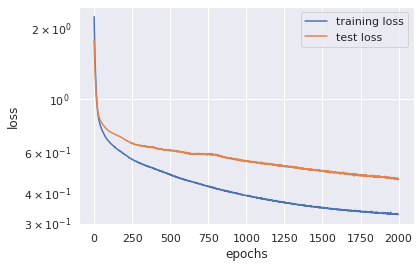

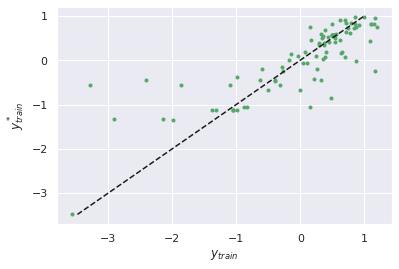

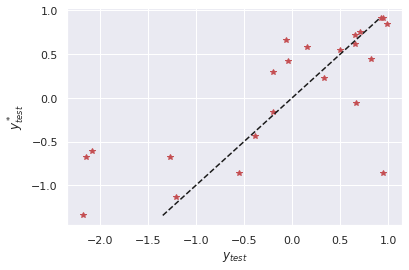

In [81]:
plt.plot(history.history['mean_squared_error'], label = 'training loss')
plt.plot(history.history['val_mean_squared_error'], label = 'test loss')
plt.yscale('log')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')

#TESTING
y_star_train = model.predict(X_train)
y_star_test = model.predict(X_test)

#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')

from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_star_test)
MSE_train = mean_squared_error(y_train, y_star_train)

print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_star_test)
print('R2_test: ',R2_test)

#METRICS: R2, RMSE, MAPE
y_pred = model.predict(X_test)
R2=r2_score(y_test, y_pred)
RMSE = np.square(np.subtract(y_test,y_pred)).mean()
print("RMSE: ", RMSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test))
print("MAPE: ", MAPE)
IM=np.sqrt((R2**2) + (RMSE**2) + (MAPE**2) )
print("IM: ", IM)
